# NLP Core 2 Exercise 1: Hot News

<b>In this exercise we will learn how to perform document classification in order to predict the category of news articles from the Reuters Corpus using a **bag-of-words** model and **one-hot encoding**. We will then see how we can use **TF-IDF** to improve our features for classification. Finally, we will perform topic modeling with **LDA** to see whether we can predict the categories of news articles without any labelled data.<b/>



## The Reuters Corpus

<b>The Reuters Corpus is a collection of news documents along with category tags that are commonly used to test document classification. It is split into two sets: the *training* documents used to train a classification algorithm, and the *test* documents used to test the classifier's performance.

The Reuters Corpus is accessible through NLTK; <br>for more information see the [NLTK Corpus HOWTO](http://www.nltk.org/howto/corpus.html#categorized-corpora).<b/>


In [1]:
from nltk.corpus import reuters
import nltk
nlp = nltk.download('reuters')
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords 
nltk.download('stopwords')
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**sourse links:**<br>https://www.nltk.org/book/ch02.html#:~:text=The%20Reuters%20Corpus%20contains%2010%2C788,drawn%20from%20the%20test%20set.<br>https://www.programcreek.com/python/example/104628/nltk.corpus.reuters.fileids<br>https://elvinouyang.github.io/project/reuters-w2v-bow-get-started/<br>https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction<br>https://medium.com/@jdwittenauer/language-exploration-using-vector-space-models-4b29745c55fb


## Questions: (please answer by direct calculation)
###  1. How many documents are in the Reuters Corpus? 

In [2]:
documents = reuters.fileids()
len(documents)

10788

### What percentage are training and what percentage are testing documents?
**% Train docs:**

In [3]:
train_docs = list(filter(lambda doc: doc.startswith("train"), documents));
str(round(len(train_docs)/len(documents)*100,2))+'%'

'72.02%'

**% Test docs:**

In [4]:
test_docs = list(filter(lambda doc: doc.startswith("test"), documents));
str(round(len(test_docs)/len(documents)*100,2))+'%'

'27.98%'

###  2. How many words are in the training documents? 

In [5]:
len(reuters.words(train_docs))

1253696

### In the testing documents?


In [6]:
len(reuters.words(test_docs))

467205

###  3. What are the five most common categories in the training documents?

In [7]:
train_cat = [reuters.categories(fileids=[f]) for f in train_docs]  

Counter([word.lower() for item in train_cat for word in item]).most_common(5)

[('earn', 2877),
 ('acq', 1650),
 ('money-fx', 538),
 ('grain', 433),
 ('crude', 389)]

## Bag of words representations

**We will now see how a sentence can be transformed into a feature vector using a bag of words model. Consider the following sentences:**

In [0]:
sentences = [
  'This is the first document.',
  'This document is the second document.',
  'And this is the third one.',
  'Is this the first document?'
]

#### We can represent each word as a **one-hot** encoded vector (with a single 1 in the column for that word), and add their vectors together to get the feature vector for a sentence:

## Questions:
###  4. Use CountVectorizer from scikit-learn to get an array of one-hot encoded vectors for the given sentences. 

In [9]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sentences)

vectorizer.get_feature_names()

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

### What do the rows and columns of the feature matrix X represent?


Each term found by the analyzer during the fit is assigned a unique integer index <br>corresponding to a column in the resulting matrix.

In [10]:
X.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]])

###  5. What word does the second column of X represent?

The vectorizer stores the feature names (words) that map to the matrix column indexes. We can inspect those if desired

In [11]:
vectorizer.get_feature_names()[1]

'document'

### What about the third column? (If you are stuck, look at *vectorizer.get_feature_names()*)
 
 

In [12]:
vectorizer.get_feature_names()[2]

'first'

**sourse link:**<br>https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.Xt4EvXX7Qu0

## Bonus:
 
### Try using TfidfVectorizer instead of CountVectorizer, and try to explain why some values of X become smaller than others.

In [13]:
tfid_vectorizer = TfidfVectorizer(use_idf=True)
X = tfid_vectorizer.fit_transform(sentences)
X.toarray()

array([[0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524],
       [0.        , 0.6876236 , 0.        , 0.28108867, 0.        ,
        0.53864762, 0.28108867, 0.        , 0.28108867],
       [0.51184851, 0.        , 0.        , 0.26710379, 0.51184851,
        0.        , 0.26710379, 0.51184851, 0.26710379],
       [0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524]])

TfidfVectorizer combines all the options of CountVectorizer and TfidfTransformer in a single model.
 
 To explain what we got in the X, we will show all important metrics and their meaning below

The inverse document frequency (IDF) is a statistical weight used for measuring the importance of a term in a text document collection. The document frequency DF of a term is defined by the number of documents in which a term appears.

In [14]:
# print idf values
df_idf = pd.DataFrame(tfid_vectorizer.idf_, 
                      index=tfid_vectorizer.get_feature_names(),
                      columns=["idf_weights"])
 
# sort ascending
df_idf.sort_values(by=['idf_weights'])
 

,idf_weights
is,1.000000
the,1.000000
this,1.000000
document,1.223144
first,1.510826
and,1.916291
one,1.916291
second,1.916291
third,1.916291


Notice that the words `is`, `the`, `this` have the lowest IDF values. This is expected as these words appear in each and every document in our collection. The lower the IDF value of a word, the less unique it is to any particular document.

**Answer:**

tf-idf is a weighting scheme that assigns each term in a document a weight based on its term frequency (tf) and inverse document frequency (idf). The terms with higher weight scores are considered to be more important.

In [15]:
# get the first vector out (for the first document)
first_vector_tfidfvectorizer=X[0]
 
# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), 
                  index=tfid_vectorizer.get_feature_names(), 
                  columns=["tfidf"])

df.sort_values(by=["tfidf"],ascending=False)
 

,tfidf
first,0.580286
document,0.469791
is,0.384085
the,0.384085
this,0.384085
and,0.000000
one,0.000000
second,0.000000
third,0.000000


# Classifying Reuters

**Now let's put these together in order to build a classifier for Reuters articles.**

## Questions:

###  6. Convert the training and testing documents into matrices X and X2 of feature vectors using CountVectorizer(), and convert the category labels into matrices y and y2 of binary features for classification using MultiLabelBinarizer() from scikit-learn. (Hint: use fit_transform() first on the training set, and then transform() on the testing set.)

**sourse link:**<br>https://www.kaggle.com/harshildarji/reuters-onevsrestclassifier#MultiLabelBinarizer

Splitting for the training and testing documents

In [0]:
train_documents, train_categories = zip(*[(reuters.raw(i), reuters.categories(i)) 
                                          for i  in train_docs])

test_documents, test_categories = zip(*[(reuters.raw(i), reuters.categories(i)) 
                                        for i in test_docs])

Converting the training and testing documents into matrices X and X2 of feature vectors using CountVectorizer()

In [0]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_documents)
X2 =  vectorizer.transform(test_documents)

Converting the category labels into matrices y and y2 of binary features for classification using MultiLabelBinarizer()

In [0]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(train_categories)
y2 = mlb.transform(test_categories)
                            


###  7. Add code to fit a multiclass SVM classifier on the training data. (Hint: use *OneVsRestClassifier(LinearSVC())* as the classifier object, and then call its fit() and predict() methods on the data.) Use sklearn.metrics.classification_report to evaluate its performance.


In [19]:
model = OneVsRestClassifier(LinearSVC())
model.fit(X, y)
y_pred = model.predict(X2)
pd.DataFrame(classification_report(y2, y_pred, output_dict=True)).T. \
style.applymap(lambda val: 'color: green' if 0.9<val <=1 else 'color: black')

,precision,recall,f1-score,support
0,0.971550,0.949930,0.960619,719.000000
1,1.000000,0.391304,0.562500,23.000000
2,1.000000,0.642857,0.782609,14.000000
3,0.777778,0.700000,0.736842,30.000000
4,0.923077,0.666667,0.774194,18.000000
5,0.000000,0.000000,0.000000,1.000000
6,1.000000,0.833333,0.909091,18.000000
7,0.000000,0.000000,0.000000,2.000000
8,0.000000,0.000000,0.000000,3.000000
9,0.928571,0.928571,0.928571,28.000000


  
## Bonus: 
### Try using TF-IDF (TfidfVectorizer) weighted features. 

Splitting for the training and testing documents

In [0]:
train_documents_tf, train_categories_tf = zip(*[(reuters.raw(i), reuters.categories(i)) 
                                          for i  in train_docs])

test_documents_tf, test_categories_tf = zip(*[(reuters.raw(i), reuters.categories(i)) 
                                        for i in test_docs])

Converting the training and testing documents into matrices X and X2 of feature vectors using TfidfVectorizer()

In [0]:
vectorizer_tf = TfidfVectorizer()
X_tf = vectorizer_tf.fit_transform(train_documents_tf)
X2_tf =  vectorizer_tf.transform(test_documents_tf)

Converting the category labels into matrices y and y2 of binary features for classification using MultiLabelBinarizer()

In [0]:
mlb_tf = MultiLabelBinarizer()
y_tf = mlb_tf.fit_transform(train_categories_tf)
y2_tf = mlb_tf.transform(test_categories_tf)
                            

Fitting a multiclass SVM classifier on the training data.  Evaluating its performance.

In [23]:
model_tf = OneVsRestClassifier(LinearSVC())
model_tf.fit(X_tf, y_tf)
y_pred_tf = model_tf.predict(X2_tf)
pd.DataFrame(classification_report(y2_tf, y_pred_tf, output_dict=True)).T. \
style.applymap(lambda val: 'color: green' if 0.9<val <=1 else 'color: black')


,precision,recall,f1-score,support
0,0.984150,0.949930,0.966737,719.000000
1,1.000000,0.391304,0.562500,23.000000
2,1.000000,0.642857,0.782609,14.000000
3,0.941176,0.533333,0.680851,30.000000
4,0.875000,0.388889,0.538462,18.000000
5,0.000000,0.000000,0.000000,1.000000
6,1.000000,0.944444,0.971429,18.000000
7,0.000000,0.000000,0.000000,2.000000
8,0.000000,0.000000,0.000000,3.000000
9,0.964286,0.964286,0.964286,28.000000


### Does the classifier's performance improve?

Yes, it does, for example features 81 and 78 have higher precision scores(as many others features)

# Topic Modeling with LDA

**Now we will see if we can use topic modeling to discover the topics in the Reuters news articles without using the labels provided in the corpus.**

## Questions:

### 8. Encode the articles as a matrix of feature vectors using one-hot encoding. Exclude stopwords by using NLTK's list of English stopwords (see *nltk.corpus.stopwords*).


**sourse link:**<br>https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/<br>https://medium.com/@yanlinc/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6

Getting stopwords

In [0]:
stop_words = set([w.lower() for w in stopwords.words('english')])

Splitting for the training and testing documents

In [0]:
train_docs_lda, train_categories_tf = zip(*[(reuters.raw(i), reuters.categories(i)) 
                                          for i  in train_docs])

test_docs_lda, test_categories_tf = zip(*[(reuters.raw(i), reuters.categories(i)) 
                                        for i in test_docs])

Encoding the articles as a matrix of feature vectors using one-hot encoding (Excluding stopwords)

In [0]:
vectorizer_lda = CountVectorizer(stop_words=stop_words)
X_lda = vectorizer_lda.fit_transform(train_docs_lda)
X2_lda = vectorizer_lda.transform(test_docs_lda)

### 9. Create a model *lda* by using scikit-learn's LatentDirichletAllocation to model the topics in the documents. Set the argument *n_components* to equal the number of categories in Reuters, and use the matrix from question 8 as input to the model's *fit_transform()* function. What does the output of this function represent?


**sourse link:**<br>https://stackoverflow.com/questions/50564099/latentdirichletallocation-python<br>

Creating a model lda  to model the topics in the documents, using the matrix from Q8

In [27]:
lda = LatentDirichletAllocation(n_components=len(reuters.categories()))

# Create Document — Topic Matrix
lda_output = lda.fit_transform(X_lda)
lda_output.shape

(7769, 90)

In [28]:
lda_output

array([[3.30687831e-05, 3.30687831e-05, 3.30687831e-05, ...,
        3.30687831e-05, 3.30687831e-05, 3.30687831e-05],
       [1.69768096e-01, 7.55857899e-05, 7.55857899e-05, ...,
        8.21921830e-02, 7.55857899e-05, 7.55857899e-05],
       [1.68350168e-04, 1.68350168e-04, 1.68350168e-04, ...,
        1.68350168e-04, 1.68350168e-04, 1.68350168e-04],
       ...,
       [5.29100529e-04, 5.29100529e-04, 5.29100529e-04, ...,
        5.29100529e-04, 5.29100529e-04, 5.29100529e-04],
       [1.63398693e-04, 1.63398693e-04, 1.63398693e-04, ...,
        1.63398693e-04, 1.63398693e-04, 1.63398693e-04],
       [3.47222222e-04, 3.47222222e-04, 3.47222222e-04, ...,
        3.47222222e-04, 3.47222222e-04, 3.47222222e-04]])

The output of this function represents the matrix of per-document topic distributions. It will l be the shape: (n_samples, n_topics), but we see changes in the average spread of probabilities for each row (document)


## Bonus:
### For documents with the categories 'trade', 'acq', and 'cocoa', print three histograms of the distribution of LDA predicted topics. (Hint: use *np.argmax* to find the most prominent topic for each document.)

Creating the table of distribution probabilities for topics in the documents on train set.
<br>Getting the dominant topic for each document and writing it into  table


In [29]:
# column names
topicnames = reuters.categories()
# index names
docnames = ['Doc' + str(i) for i in range(len(train_docs_lda))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(lda_output, 
                                 columns=topicnames, 
                                 index=docnames)

dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.head()

,acq,alum,barley,bop,carcass,castor-oil,cocoa,coconut,coconut-oil,coffee,copper,copra-cake,corn,cotton,cotton-oil,cpi,cpu,crude,dfl,dlr,dmk,earn,fuel,gas,gnp,gold,grain,groundnut,groundnut-oil,heat,hog,housing,income,instal-debt,interest,ipi,iron-steel,jet,jobs,l-cattle,...,nkr,nzdlr,oat,oilseed,orange,palladium,palm-oil,palmkernel,pet-chem,platinum,potato,propane,rand,rape-oil,rapeseed,reserves,retail,rice,rubber,rye,ship,silver,sorghum,soy-meal,soy-oil,soybean,strategic-metal,sugar,sun-meal,sun-oil,sunseed,tea,tin,trade,veg-oil,wheat,wpi,yen,zinc,dominant_topic
Doc0,0.000033,0.000033,0.000033,0.032612,0.308834,0.000033,0.000033,0.000033,0.016930,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.054911,0.000033,0.000033,...,0.000033,0.000033,0.078442,0.000033,0.000033,0.000033,0.042062,0.064020,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.096498,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.051215,0.000033,0.025521,0.000033,0.000033,0.003103,0.000033,0.000033,0.000033,0.000033,4
Doc1,0.169768,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.042550,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,...,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.372738,0.000076,0.000076,0.000076,0.000076,0.326327,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.082192,0.000076,0.000076,72
Doc2,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.068924,0.655380,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,...,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.046771,0.000168,0.000168,0.000168,0.141982,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,8
Doc3,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,...,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.040131,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.895137,0.000125,0.000125,87
Doc4,0.172226,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.191606,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,...,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.052608,0.000176,0.000176,0.568392,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,

Getting Topic-Keyword Matrix for 'trade', 'acq' and 'cocoa' topics

In [30]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer_lda.get_feature_names()
df_topic_keywords.index = reuters.categories()
# View
df_topic_keywords.reset_index(inplace=True)
df_topic_keywords.rename(columns={"level_0": "Topics"}, inplace=True)
df_topic_keywords.loc[df_topic_keywords['Topics'].isin(['trade', 'acq', 'cocoa'])].T


,0,6,84
Topics,acq,cocoa,trade
00,0.0111111,0.0111111,6.87119
000,67.8021,0.497855,110.255
0000,0.0111111,0.0111111,0.0111111
00000,0.0111111,0.0111111,0.0111111
...,...,...,...
zurich,0.0111111,0.0111111,0.0111111
zuyuan,0.0111111,0.0111111,0.0111111
zverev,0.0111111,0.0111111,0.0111111
zy,0.0111111,0.0111111,0.0111111


 Show top 15 keywords for 'trade', 'acq' and 'cocoa' topics

In [31]:

def show_topics(vectorizer=vectorizer_lda, lda_model=lda, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer_lda, lda_model=lda, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)

df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords["Topics"]=reuters.categories()
df_topic_keywords.loc[df_topic_keywords['Topics'].isin(['trade', 'acq', 'cocoa'])].T


,Topic 0,Topic 6,Topic 84
Word 0,lt,said,said
Word 1,said,singapore,gold
Word 2,inc,ltd,ounces
Word 3,corp,quota,000
Word 4,unit,two,mine
Word 5,company,cpb,ton
Word 6,dlrs,system,ounce
Word 7,acquisition,mulroney,silver
Word 8,sale,general,per
Word 9,co,last,feet


Define function to predict topic for a given text document.

In [0]:

def predict(text=test_docs_lda,vectorizer_lda=vectorizer_lda, model=lda):
    X2_lda = vectorizer_lda.transform(text)
    topic_probability_scores = model.transform(X2_lda)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores,axis=1 ),\
                                   :14].values.tolist()
        
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores,axis=1),-1]
    topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores,axis=1)]
    
    return topic,infer_topic,topic_guess,topic_probability_scores


 Predict the topic on test set

In [33]:
topic,infer_topic,topic_guess,topic_probability_scores_test = predict()
print(topic[:5])
print(infer_topic[:5])
topic_guess.head()

[['trade', 'said', 'would', 'ec', 'states', 'united', 'countries', 'japan', 'officials', 'bill', 'reagan', 'told', 'house', 'foreign'], ['tonnes', 'mln', 'said', 'production', 'crop', 'year', 'last', '000', 'grain', '1986', 'wheat', '87', 'season', 'output'], ['said', 'dollar', 'economic', 'would', 'government', 'exchange', 'economy', 'currency', 'growth', 'foreign', 'last', 'policy', 'market', 'bank'], ['quarter', 'dlrs', 'said', 'year', 'earnings', 'share', 'company', 'first', '1987', '1986', 'expects', 'fourth', 'per', 'fiscal'], ['oil', 'said', 'indonesia', 'would', 'world', 'crude', 'ecuador', 'exports', 'mln', 'palm', 'official', 'told', 'countries', 'pipeline']]
Topic 43       livestock
Topic 4          carcass
Topic 47    money-supply
Topic 60        platinum
Topic 12            corn
Name: Topics, dtype: object


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 43,trade,said,would,ec,states,united,countries,japan,officials,bill,reagan,told,house,foreign,administration,livestock
Topic 4,tonnes,mln,said,production,crop,year,last,000,grain,1986,wheat,87,season,output,weather,carcass
Topic 47,said,dollar,economic,would,government,exchange,economy,currency,growth,foreign,last,policy,market,bank,trade,money-supply
Topic 60,quarter,dlrs,said,year,earnings,share,company,first,1987,1986,expects,fourth,per,fiscal,sees,platinum
Topic 12,oil,said,indonesia,would,world,crude,ecuador,exports,mln,palm,official,told,countries,pipeline,year,corn


Creating the table of distribution probabilities for topics in the documents on ttest set.<br>
Getting the dominant topic for each document and writing it into table

In [34]:
# column names
topicnames = reuters.categories()
# index names
docnames = ['Doc' + str(i) for i in range(len(test_docs_lda))]
# Make the pandas dataframe
df_document_topic_test = pd.DataFrame(topic_probability_scores_test, 
                                 columns=topicnames, 
                                 index=docnames)

dominant_topic_t = np.argmax(df_document_topic_test.values, axis=1)
df_document_topic_test['dominant_topic'] = dominant_topic_t
df_document_topic_test

,acq,alum,barley,bop,carcass,castor-oil,cocoa,coconut,coconut-oil,coffee,copper,copra-cake,corn,cotton,cotton-oil,cpi,cpu,crude,dfl,dlr,dmk,earn,fuel,gas,gnp,gold,grain,groundnut,groundnut-oil,heat,hog,housing,income,instal-debt,interest,ipi,iron-steel,jet,jobs,l-cattle,...,nkr,nzdlr,oat,oilseed,orange,palladium,palm-oil,palmkernel,pet-chem,platinum,potato,propane,rand,rape-oil,rapeseed,reserves,retail,rice,rubber,rye,ship,silver,sorghum,soy-meal,soy-oil,soybean,strategic-metal,sugar,sun-meal,sun-oil,sunseed,tea,tin,trade,veg-oil,wheat,wpi,yen,zinc,dominant_topic
Doc0,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.011627,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.096776,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.004838,0.000025,0.000025,0.000025,0.000025,0.006526,0.000025,0.014152,0.000025,0.000025,0.000025,0.021601,...,0.000025,0.000025,0.030102,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.000025,0.019276,0.165420,0.000025,0.000025,0.000025,0.015726,0.009899,0.000025,0.000025,0.000025,0.000025,0.003840,0.000025,0.000025,0.000025,0.000025,0.006879,0.000025,0.000025,0.015292,0.000025,0.022433,43
Doc1,0.000161,0.000161,0.077351,0.000161,0.294368,0.000161,0.060356,0.096367,0.032080,0.000161,0.081709,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.042372,0.000161,0.036068,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.029057,0.000161,0.000161,0.158799,0.000161,0.000161,0.000161,0.000161,...,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.020795,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,4
Doc2,0.000093,0.018818,0.000093,0.000093,0.000093,0.000093,0.000093,0.163060,0.035063,0.000093,0.000093,0.014140,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.106459,0.000093,0.010639,0.000093,0.000093,0.000093,0.019786,0.000093,0.000093,0.000093,0.032699,0.222148,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,...,0.000093,0.000093,0.000093,0.000093,0.096876,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.015651,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.024077,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,0.000093,47
Doc3,0.000097,0.000097,0.000097,0.116976,0.000097,0.000097,0.010092,0.135239,0.154618,0.000097,0.000097,0.011232,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.011593,0.015068,0.000097,0.000097,0.000097,0.000097,0.035597,0.000097,0.000097,0.030149,0.000097,0.000097,...,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.011629,0.190150,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.060780,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.000097,0.015702,0.000097,0.000097,0.000097,0.000097,0.000097,60
Doc4,0.000102,0.000102,0.000102,0.000102,0.147515,0.000102,0.000102,0.073373,0.013658,0.000102,0.000102,0.000102,0.357671,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.009890,0.000102,0.000102,0.000102,0.000102,0.000102,0.010336,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.012729,0.036051,0.011527,0.000102,...,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.020371,0.000102,0.063219,0.000102,0.000102,0.082637,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102

Comparing histogram of the distribution dominant topics in Train and Test sets




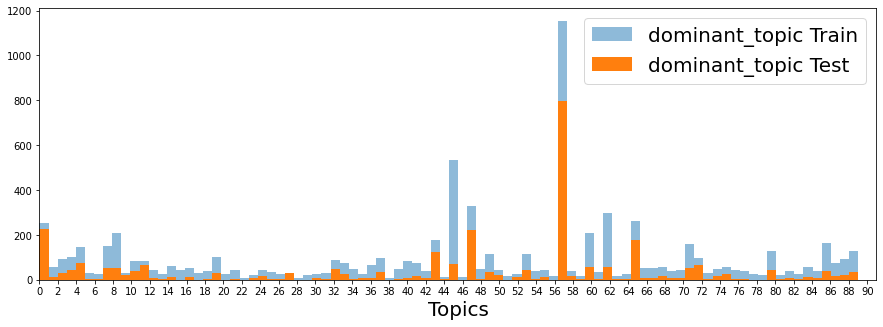

In [35]:

df_document_topic.dominant_topic.hist(bins=90,alpha=0.5,grid=False,figsize=(18,5),
                                      label='dominant_topic Train')

df_document_topic_test.dominant_topic.hist(bins=90,grid=False,figsize=(15,5),
                                           label='dominant_topic Test')
plt.xlabel('Topics',fontsize=20)
plt.xlim(0,91)
plt.xticks(np.arange(0,91,2))
plt.legend(fontsize=20);

Histogram of the distribution  predicted `acq` topic for train and test sets

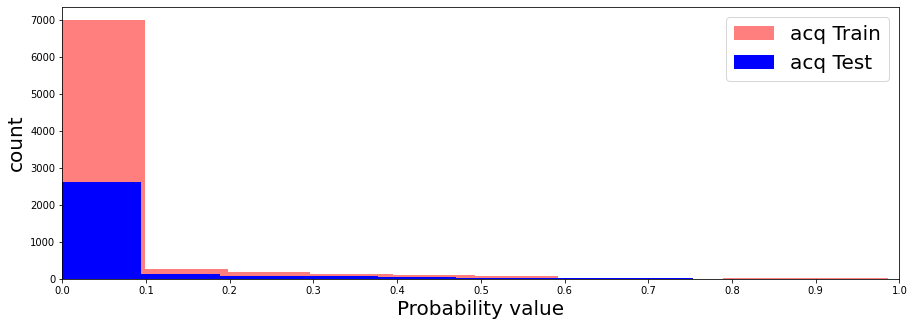

In [36]:
df_document_topic.acq.hist(color='red',alpha=0.5,grid=False,
                           figsize=(15,5),label='acq Train')

df_document_topic_test.acq.hist(color='blue',grid=False,
                                figsize=(15,5),label='acq Test')

plt.xlabel('Probability value',fontsize=20)
plt.ylabel('count',fontsize=20)

plt.xlim(0,1)
plt.xticks(np.arange(0,1.1,0.1))
plt.legend(fontsize=20);

Histogram of the distribution  predicted `cocoa` topic for train and test sets





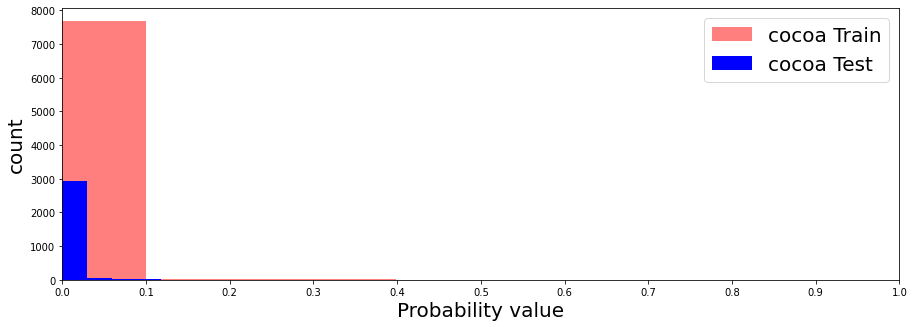

In [37]:
df_document_topic.cocoa.hist(color='red',alpha=0.5,grid=False,figsize=(15,5),label='cocoa Train')
df_document_topic_test.cocoa.hist(color='blue',grid=False,figsize=(15,5),label='cocoa Test')
plt.xlabel('Probability value',fontsize=20)
plt.ylabel('count',fontsize=20)

plt.xlim(0,1)
plt.xticks(np.arange(0,1.1,0.1))
plt.legend(fontsize=20);

Histogram of the distribution  predicted `trade` topic for train and test sets


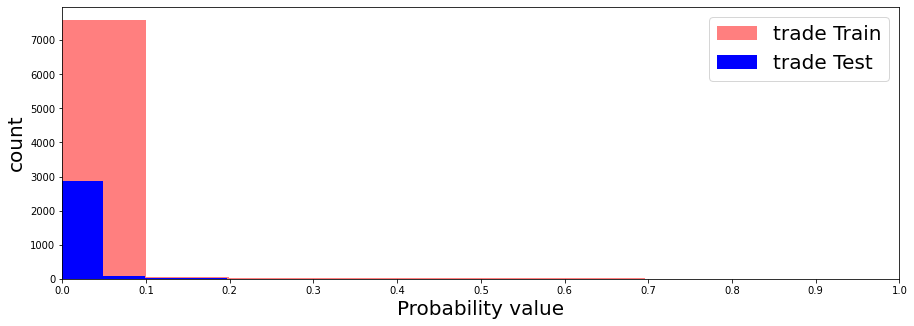

In [38]:
df_document_topic.trade.hist(color='red',alpha=0.5,grid=False,figsize=(15,5),label='trade Train')
df_document_topic_test.trade.hist(color='blue',grid=False,figsize=(15,5),label='trade Test') 
plt.xlabel('Probability value',fontsize=20)
plt.ylabel('count',fontsize=20)

plt.xlim(0,1)
plt.xticks(np.arange(0,1.1,0.1))
plt.legend(fontsize=20);